# (15m) SNR

author: steeve.laquitaine@epfl.ch  
status: up-to-date
last modified: 15.07.2024

**Method**

* SNR for first 10 mins (for speed)

Formatting figure: max 180 mm (7 inches; NN guide)

Q: Why does the biophy model of denser recording have larger amplitude-to-noise ratio than in vivo despite the fact that his noise and gain are fitted.
* Noise and gain fitting method:
  * over entire traces
  * noise added only to sites in layers (sites within cortex)
* We show here the first 10 minutes, which might not contain the same max absolute amplitude.
* Biophy traces per layer must be matched to the layers they were fitted against. They were fitted against site traces in the same layer at the same depth.
  * model probe 1, layer 1 -> in vivo probe 1 layer 1 - VALIDATED!
  * model probe 1, layer 2/3 -> in vivo probe 1 layer 2/3 - VALIDATED!
  * model probe 2, layer 2/3 -> in vivo probe 2 layer 2/3 - should be skipped?
  * model probe 2, layer 4 -> in vivo probe 2 layer 4
  * model probe 2, layer 5 -> in vivo probe 2 layer 5
  * model probe 3, layer 6 -> in vivo probe 3 layer 6


### Prerequisites

These pipelines must have been run before:

1. fit silico amplitude and noise to in vivo per layer:

```bash
sbatch cluster/processing/fitting/marques/fit_marques_silico_l1.sbatch
sbatch cluster/processing/fitting/marques/fit_marques_silico_l2_3.sbatch
sbatch cluster/processing/fitting/marques/fit_marques_silico_l4.sbatch
sbatch cluster/processing/fitting/marques/fit_marques_silico_l5.sbatch
sbatch cluster/processing/fitting/marques/fit_marques_silico_l6.sbatch
```

2. Process silico traces:

```bash
sbatch cluster/prepro/marques_silico/process.sbatch
```

### (1m)Setup

Activate python3.9.7's spikeinterface 0.100.5 venv

In [1]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import os
import multiprocessing
import torch
import numpy as np
from matplotlib import pyplot as plt
import spikeinterface as si

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023/"
os.chdir(PROJ_PATH)

from src.nodes import utils
from src.nodes.utils import get_config
from src.nodes.validation import snr
from src.nodes.validation import amplitude as amp

# neuropixels ------
# neuropixels (Marques)
cfg_nv, _ = get_config("vivo_marques", "c26").values() 
RAW_PATH_nv = cfg_nv["raw"]
PREP_PATH_nv = cfg_nv["preprocessing"]["output"]["trace_file_path"]
SNR_PATH_nv = cfg_nv["validation"]["10m"]["trace_snr"]

# neuropixels (biophysical model)
cfg_ns, param_conf_ns = get_config("silico_neuropixels", "concatenated").values()
RAW_PATH_ns = cfg_ns["probe_wiring"]["40m"]["output_noise_fitd_gain_fitd_adj10perc_less_int16"]
PREP_PATH_ns = cfg_ns["preprocessing"]["output"]["full"]["trace_file_path_gain_fitd_adj10perc_less_noise_fitd_int16"]
SNR_PATH_ns = cfg_ns["validation"]["10m"]["trace_snr_adj10perc_less_noise_fitd_int16"]

# neuropixels (evoked biophysical model)
cfg_ne, _ = get_config("silico_neuropixels", "stimulus").values()
RAW_PATH_ne = cfg_ne["probe_wiring"]["output"]
PREP_PATH_ne = cfg_ne["preprocessing"]["output"]["full"]["trace_file_path_gain_fitd_adj10perc_less_noise_fitd_int16"]
SNR_PATH_ne = cfg_ne["validation"]["10m"]["trace_snr"]

# neuropixels (synthetic, Buccino)
cfg_nb, param_conf_nb = get_config("buccino_2020", "2020").values()
RAW_PATH_nb = cfg_nb["probe_wiring"]["10m"]["output_gain_fitd_int16"]
PREP_PATH_nb = cfg_nb["preprocessing"]["output"]["trace_file_path_gain_ftd"]
SNR_PATH_nb = cfg_nb["validation"]["10m"]["trace_snr"]

# custom probe (horvath)  ------
# vivo (probe 1)
cfg_hv1, _ = get_config("vivo_horvath", "probe_1").values()
RAW_PATH_hv1 =  cfg_hv1["raw"]
PREP_PATH_hv1 = cfg_hv1["preprocessing"]["output"]["trace_file_path"]
SNR_PATH_hv1 = cfg_hv1["validation"]["10m"]["trace_snr"]
# probe 2
cfg_hv2, _ = get_config("vivo_horvath", "probe_2").values()
RAW_PATH_hv2 =  cfg_hv2["raw"]
PREP_PATH_hv2 = cfg_hv2["preprocessing"]["output"]["trace_file_path"]
SNR_PATH_hv2 = cfg_hv2["validation"]["10m"]["trace_snr"]
# probe 3
cfg_hv3, _ = get_config("vivo_horvath", "probe_3").values()
RAW_PATH_hv3 =  cfg_hv3["raw"]
PREP_PATH_hv3 = cfg_hv3["preprocessing"]["output"]["trace_file_path"]
SNR_PATH_hv3 = cfg_hv3["validation"]["10m"]["trace_snr"]

# biophy. model
# (probe 1)
cfg_hs1, _ = get_config("silico_horvath", "concatenated/probe_1").values()
RAW_PATH_hs1 = cfg_hs1["dataeng"]["campaign"]["output"]["trace_file_path"]
PREP_PATH_hs1 = cfg_hs1["preprocessing"]["output"]["trace_file_path"]
SNR_PATH_hs1 = cfg_hs1["validation"]["10m"]["trace_snr"]
# probe 2
cfg_hs2, _ = get_config("silico_horvath", "concatenated/probe_2").values()
RAW_PATH_hs2 = cfg_hs2["dataeng"]["campaign"]["output"]["trace_file_path"]
PREP_PATH_hs2 = cfg_hs2["preprocessing"]["output"]["trace_file_path"]
SNR_PATH_hs2 = cfg_hs2["validation"]["10m"]["trace_snr"]
# probe 3
cfg_hs3, _ = get_config("silico_horvath", "concatenated/probe_3").values()
RAW_PATH_hs3 = cfg_hs3["dataeng"]["campaign"]["output"]["trace_file_path"]
PREP_PATH_hs3 = cfg_hs3["preprocessing"]["output"]["trace_file_path"]
SNR_PATH_hs3 = cfg_hs3["validation"]["10m"]["trace_snr"]

# sampling frequency
SFREQ_NV = 30000        
SFREQ_NS = 40000
SFREQ_NE = 20000
SFREQ_HV = 20000        
SFREQ_HS = 20000

# FIGURE SETTINGS
FIG_SIZE = (1.5, 6)
# experiment colors
COLOR_NV = np.array([153, 153, 153]) / 255 # light gray
COLOR_NS = [0.9, 0.14, 0.15] # red
COLOR_HV = [0.2, 0.2, 0.2] # dark gray
COLOR_HS = np.array([26, 152, 80]) / 255 # green
COLOR_NB = [0.22, 0.5, 0.72] # blue
COLOR_NE = [1, 0.49, 0]  # orange

# axes aesthetics
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically 0.5 - 1 pt
plt.rcParams["axes.linewidth"] = 0.5 # typically 0.5 - 1 pt
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
N_MAJOR_TICKS = 4
N_MINOR_TICKS = 12
savefig_cfg = {"transparent":True, "dpi":300}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False              # no legend frame

2024-07-18 18:53:37,915 - root - utils.py - get_config - INFO - Reading experiment config.
2024-07-18 18:53:37,960 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-07-18 18:53:37,961 - root - utils.py - get_config - INFO - Reading experiment config.
2024-07-18 18:53:38,046 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-07-18 18:53:38,047 - root - utils.py - get_config - INFO - Reading experiment config.
2024-07-18 18:53:38,091 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-07-18 18:53:38,092 - root - utils.py - get_config - INFO - Reading experiment config.
2024-07-18 18:53:38,132 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-07-18 18:53:38,133 - root - utils.py - get_config - INFO - Reading experiment config.
2024-07-18 18:53:38,154 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-07-18 18:53:38,154 - root - utils.py - get_config 

### Specs

In [2]:
# cpus, gpu and current memory usage
print("available cpus:", multiprocessing.cpu_count())
print("available gpus:", torch.cuda.is_available())
%system free -m

available cpus: 72
available gpus: False


['              total        used        free      shared  buff/cache   available',
 'Mem:         385269       17555      366234          98        1479      366599',
 'Swap:             0           0           0']

### (1s)Load datasets

* first 10 minutes of recordings
* for sites in cortex
* we plot: 
    * on logscale to increase the visibility of the SNR dist. which decays exponentially.
    * only the upper confidence interval (because the lower ci is uninformative; it goes to infinity when negative on a logscale)

In [3]:
# 1 - Load silico and vivo traces
# neuropixels
RecNS = si.load_extractor(PREP_PATH_ns)
RecNV = si.load_extractor(PREP_PATH_nv)
RecNB = si.load_extractor(PREP_PATH_nb)
RecNE = si.load_extractor(PREP_PATH_ne)
# horvath
# probe 1
RecHS1 = si.load_extractor(PREP_PATH_hs1)
RecHV1 = si.load_extractor(PREP_PATH_hv1)
# probe 2
RecHS2 = si.load_extractor(PREP_PATH_hs2)
RecHV2 = si.load_extractor(PREP_PATH_hv2)
# probe 3
RecHS3 = si.load_extractor(PREP_PATH_hs3)
RecHV3 = si.load_extractor(PREP_PATH_hv3)

# 2. get first 10 mins
# neuropixels
RecNV = RecNV.frame_slice(start_frame=0, end_frame=10 * 60 * SFREQ_NV)
RecNS = RecNS.frame_slice(start_frame=0, end_frame=10 * 60 * SFREQ_NS)
RecNE = RecNE.frame_slice(start_frame=0, end_frame=10 * 60 * SFREQ_NE)
# horvath
# probe 1
RecHV1 = RecHV1.frame_slice(start_frame=0, end_frame=10 * 60 * SFREQ_HV)
RecHS1 = RecHS1.frame_slice(start_frame=0, end_frame=10 * 60 * SFREQ_HS)
# probe 2
RecHV2 = RecHV2.frame_slice(start_frame=0, end_frame=10 * 60 * SFREQ_HV)
RecHS2 = RecHS2.frame_slice(start_frame=0, end_frame=10 * 60 * SFREQ_HS)
# probe 3
RecHV3 = RecHV3.frame_slice(start_frame=0, end_frame=10 * 60 * SFREQ_HV)
RecHS3 = RecHS3.frame_slice(start_frame=0, end_frame=10 * 60 * SFREQ_HS)

# 3. get traces
# neuropixels
traces_ns = RecNS.get_traces()
traces_nv = RecNV.get_traces()
traces_nb = RecNB.get_traces()
traces_ne = RecNE.get_traces()
# horvath
# probe 1
traces_hs1 = RecHS1.get_traces()
traces_hv1 = RecHV1.get_traces()
# probe 2
traces_hs2 = RecHS2.get_traces()
traces_hv2 = RecHV2.get_traces()
# probe 3
traces_hs3 = RecHS3.get_traces()
traces_hv3 = RecHV3.get_traces()

# 4 - get good sites (in cortex)
# neuropixels
lyrs = ["L1", "L2_3", "L4", "L5", "L6"]
# silico
site_ly_ns = RecNS.get_property("layers")
site_ly_ns[site_ly_ns == "L2"] = "L2_3"
site_ly_ns[site_ly_ns == "L3"] = "L2_3"
sites_ns = np.where(np.isin(site_ly_ns, lyrs))[0]
# evoked
site_ly_ne = RecNE.get_property("layers")
site_ly_ne[site_ly_ne == "L2"] = "L2_3"
site_ly_ne[site_ly_ne == "L3"] = "L2_3"
sites_ne = np.where(np.isin(site_ly_ne, lyrs))[0]
# vivo
site_ly_nv = RecNV.get_property("layers")
sites_nv = np.where(np.isin(site_ly_nv, lyrs))[0]

# horvath
# silico
# probe 1 (select L1, L2/3)
site_ly_hs1 = RecHS1.get_property("layers")
site_ly_hs1 = np.array(["L2_3" if x == "L2" or x == "L3" else x for x in site_ly_hs1])
sites_hs1 = np.where(np.isin(site_ly_hs1, ["L1", "L2_3"]))[0]
# probe 2 (select L4 and L5)
site_ly_hs2 = RecHS2.get_property("layers")
sites_hs2 = np.where(np.isin(site_ly_hs2, ["L4", "L5"]))[0]
# probe 3 (select L6)
site_ly_hs3 = RecHS3.get_property("layers")
site_ly_hs3 = np.array(["L2_3" if x == "L2" or x == "L3" else x for x in site_ly_hs3])
sites_hs3 = np.where(np.isin(site_ly_hs3, ["L6"]))[0]

# vivo
# probe 1 (select L1, L2/3)
site_ly_hv1 = RecHV1.get_property("layers")
sites_hv1 = np.where(np.isin(site_ly_hv1, ["L1", "L2_3"]))[0]
# probe 2 (select L4, L5)
site_ly_hv2 = RecHV2.get_property("layers")
sites_hv2 = np.where(np.isin(site_ly_hv2, ["L4", "L5"]))[0]
# probe 3 (select L6)
site_ly_hv3 = RecHV3.get_property("layers")
sites_hv3 = np.where(np.isin(site_ly_hv3, ["L6"]))[0]

### (35m)Compute snrs

* uncomment and run or load if dataset has been exists

In [4]:
## (9m)compute snrs and save
# snr_ns = snr.get_snrs_parallel(traces_ns[:, sites_ns])
# snr_nv = snr.get_snrs_parallel(traces_nv[:, sites_nv])
# snr_nb = snr.get_snrs_parallel(traces_nb)
# snr_ne = snr.get_snrs_parallel(traces_ne[:, sites_ne])
# utils.write_npy(snr_nv, SNR_PATH_nv)
# utils.write_npy(snr_ns, SNR_PATH_ns)
# utils.write_npy(snr_nb, SNR_PATH_nb)
# utils.write_npy(snr_ne, SNR_PATH_ne)

# # horvath probe
# # compute and save
# snr_hv1 = snr.get_snrs_parallel(traces_hv1[:, sites_hv1])
# snr_hv2 = snr.get_snrs_parallel(traces_hv2[:, sites_hv2])
# snr_hv3 = snr.get_snrs_parallel(traces_hv3[:, sites_hv3])
# snr_hs1 = snr.get_snrs_parallel(traces_hs1[:, sites_hs1])
# snr_hs2 = snr.get_snrs_parallel(traces_hs2[:, sites_hs2])
# snr_hs3 = snr.get_snrs_parallel(traces_hs3[:, sites_hs3])
# utils.write_npy(snr_hv1, SNR_PATH_hv1)
# utils.write_npy(snr_hv2, SNR_PATH_hv2)
# utils.write_npy(snr_hv3, SNR_PATH_hv3)
# utils.write_npy(snr_hs1, SNR_PATH_hs1)
# utils.write_npy(snr_hs2, SNR_PATH_hs2)
# utils.write_npy(snr_hs3, SNR_PATH_hs3)

# (47s) or load neuropixels data
snr_nv = np.load(SNR_PATH_nv)
snr_ns = np.load(SNR_PATH_ns)
snr_nb = np.load(SNR_PATH_nb)
snr_ne = np.load(SNR_PATH_ne)

# or load custom probe (Horvath) data
snr_hv1 = np.load(SNR_PATH_hv1)
snr_hs1 = np.load(SNR_PATH_hs1)
snr_hv2 = np.load(SNR_PATH_hv2)
snr_hs2 = np.load(SNR_PATH_hs2)
snr_hv3 = np.load(SNR_PATH_hv3)
snr_hs3 = np.load(SNR_PATH_hs3)

#### (1s)get traces in cortex

In [5]:
# (5m) select traces in cortex
# neuropixels
site_ly_ns = site_ly_ns[sites_ns]  # silico
site_ly_ne = site_ly_ne[sites_ne]  # evoked
site_ly_nv = site_ly_nv[sites_nv]  # vivo

# custom (horvath)
# biophy
site_ly_hs1 = site_ly_hs1[sites_hs1]  # probe 1 (L1, L2/3)
site_ly_hs2 = site_ly_hs2[sites_hs2]  # probe 2 (L4, L5)
site_ly_hs3 = site_ly_hs3[sites_hs3]  # probe 3

# vivo
site_ly_hv1 = site_ly_hv1[sites_hv1]  # probe 1
site_ly_hv2 = site_ly_hv2[sites_hv2]  # probe 2
site_ly_hv3 = site_ly_hv3[sites_hv3]  # probe 3

### (4m)Compute pdfs

In [6]:
# (40s) get common bins across experiments (2 mins)
N_BINS = 100

# max observed snr
snr_max = np.max(
    [
        np.max(snr_nv),
        np.max(snr_ns),
        np.max(snr_nb),
        np.max(snr_ne),
        np.max(snr_hv1),
        np.max(snr_hv2),
        np.max(snr_hv3),
        np.max(snr_hs1),
        np.max(snr_hs2),
        np.max(snr_hs3),
    ]
)
# min observed snr
snr_min = np.min(
    [
        np.min(snr_nv),
        np.min(snr_ns),
        np.min(snr_nb),
        np.min(snr_ne),
        np.min(snr_hv1),
        np.min(snr_hv2),
        np.min(snr_hv3),
        np.min(snr_hs1),
        np.min(snr_hs2),
        np.min(snr_hs3),
    ]
)
step = (snr_max - snr_min) / N_BINS
bins = np.arange(snr_min, snr_max + step / 2, step)


# (3m) get the mean, 95% CI of SNR pdfs over sites (1 min)
# neuropixels -------------
# vivo
mean_nv, ci_nv, by_site_nv = amp.get_snr_pdfs(snr_nv, bins)
# silico
mean_ns, ci_ns, by_site_ns = amp.get_snr_pdfs(snr_ns, bins)
# buccino
mean_nb, ci_nb, by_site_nb = amp.get_snr_pdfs(snr_nb, bins)
# evoked
mean_ne, ci_ne, by_site_ne = amp.get_snr_pdfs(snr_ne, bins)


# custom (horvath) -------------
# vivo
mean_hv1, ci_hv1, by_site_hv1 = amp.get_snr_pdfs(snr_hv1, bins)
mean_hv2, ci_hv2, by_site_hv2 = amp.get_snr_pdfs(snr_hv2, bins)
mean_hv3, ci_hv3, by_site_hv3 = amp.get_snr_pdfs(snr_hv3, bins)
# silivo
mean_hs1, ci_hs1, by_site_hs1 = amp.get_snr_pdfs(snr_hs1, bins)
mean_hs2, ci_hs2, by_site_hs2 = amp.get_snr_pdfs(snr_hs2, bins)
mean_hs3, ci_hs3, by_site_hs3 = amp.get_snr_pdfs(snr_hs3, bins)

# Compute mean and CI over all sites pooling L1, L2/3 (probe 1), L4,5 (probe 2), L6 (probe 3) horvath
# pool
pooled_hv = (
    by_site_hv1["pdf_by_site"] + by_site_hv2["pdf_by_site"] + by_site_hv3["pdf_by_site"]
)
pooled_hs = (
    by_site_hs1["pdf_by_site"] + by_site_hs2["pdf_by_site"] + by_site_hs3["pdf_by_site"]
)
# get mean and ci
mean_hv, ci_hv = snr.get_pdf_mean_ci(pooled_hv)
mean_hs, ci_hs = snr.get_pdf_mean_ci(pooled_hs)

# unit-test probabilities
# neuropixels
assert 1 - sum(mean_nv) < 1e-15, "should sum to 1"
assert 1 - sum(mean_ns) < 1e-15, "should sum to 1"
assert 1 - sum(mean_nb) < 1e-15, "should sum to 1"
assert 1 - sum(mean_ne) < 1e-15, "should sum to 1"

# custom (horvath)
assert 1 - sum(mean_hv1) < 1e-15, "should sum to 1"
assert 1 - sum(mean_hv2) < 1e-15, "should sum to 1"
assert 1 - sum(mean_hv3) < 1e-15, "should sum to 1"
assert 1 - sum(mean_hs1) < 1e-15, "should sum to 1"
assert 1 - sum(mean_hs2) < 1e-15, "should sum to 1"
assert 1 - sum(mean_hs3) < 1e-15, "should sum to 1"

### (12m) Plot

* The dots below the x-axis line goes to -inf on a log scale because they are never observed (probability = 0)
* We made sure that the model SNRs are matched to the same in vivo depth and layers against which noise and gain were fitted. For example, model SNR from layer 1 at depth 2 is matched against SNR from layer 1 at depth 2.
* Results:
    * L4 highest amplitude-to-noise ratio

* CURRENT ISSUE: the peak ANR should nearly match b/w model and data for all sites, because peak amplitude were fitted. They likely don't because we need to plot the anr dist. for all sites over the entire recordings to check.


In [7]:
## set parameters
# pm = {
#     "linestyle": "-",
#     "linewidth": 0.5,
#     "marker": ".",
#     "markersize": 3.5,
#     "markeredgewidth": 0.01,
#     "markeredgecolor": "w",
# }
pm = {
    "linestyle": "-",
    "linewidth": 1,
    "marker": "None",
}

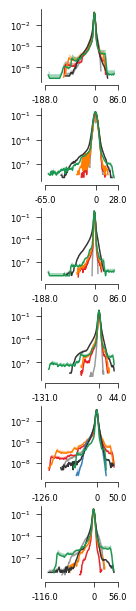

In [8]:
# plot
FIG_SIZE = (1.5, 6)
fig, ax = plt.subplots(6, 1, figsize=FIG_SIZE)

# all sites ********************************

# neuropixels
ax[0] = amp.plot_snr_pdf_all(
    ax[0],
    mean_nv,
    mean_ns,
    mean_ne,
    ci_nv,
    ci_ns,
    ci_ne,
    bins,
    COLOR_NV,
    COLOR_NS,
    COLOR_NE,
    pm,
)
# Horvath
ax[0] = amp.plot_snr_pdf_all(
    ax[0],
    mean_hv,
    mean_hs,
    [0],
    ci_hv,
    ci_hs,
    [0],
    bins,
    COLOR_HV,
    COLOR_HS,
    [0],
    pm,
)

xmin, xmax = ax[0].get_xlim()
ax[0].set_xticks([np.floor(xmin), 0, np.ceil(xmax)], [np.floor(xmin), 0, np.ceil(xmax)])
ax[0].set_xlim([np.floor(xmin), np.ceil(xmax)])


# L1 ********************************

# neuropixels
ax[1], binsl1n = snr.plot_layer_snr_npx(
    ax[1],
    "L1",
    site_ly_ns,
    site_ly_nv,
    site_ly_ne,
    snr_ns,
    snr_nv,
    snr_ne,
    100,
    COLOR_NS,
    COLOR_NV,
    COLOR_NE,
    "npx (Biophy.)",
    "npx (Marques-Smith)",
    "npx (Biophy. evoked)",
    pm,
)
# horvath
# - we make sure that the biophy model SNR is calculated
# in L1 against the in vivo sites from the same depth and layer
# (probe 1, L1)
ax[1], binsl1h = snr.plot_layer_snr_horv(
    ax[1],
    "L1",
    site_ly_hs1,  # probe 1
    site_ly_hv1,  # probe 1
    snr_hs1,  # probe 1
    snr_hv1,  # probe 1
    100,
    COLOR_HS,
    COLOR_HV,
    "custom (Biophy.)",
    "custom (Horvath)",
    pm,
)

xmin, xmax = ax[1].get_xlim()
ax[1].set_xticks([np.floor(xmin), 0, np.ceil(xmax)], [np.floor(xmin), 0, np.ceil(xmax)])
ax[1].set_xlim([np.floor(xmin), np.ceil(xmax)])

# L2/3 ********************************

# neuropixels
ax[2], binsl23n = snr.plot_layer_snr_npx(
    ax[2],
    "L2_3",
    site_ly_ns,
    site_ly_nv,
    site_ly_ne,
    snr_ns,
    snr_nv,
    snr_ne,
    100,
    COLOR_NS,
    COLOR_NV,
    COLOR_NE,
    "npx (Biophy.)",
    "npx (Marques-Smith)",
    "npx (Biophy. evoked)",
    pm,
)
# custom (probe 1, layer 2/3)
ax[2], binsl23h = snr.plot_layer_snr_horv(
    ax[2],
    "L2_3",
    site_ly_hs1,  # probe 1
    site_ly_hv1,  # probe 1
    snr_hs1,  # probe 1
    snr_hv1,  # probe 1
    100,
    COLOR_HS,
    COLOR_HV,
    "custom (Biophy.)",
    "custom (Horvath)",
    pm,
)

xmin, xmax = ax[2].get_xlim()
ax[2].set_xticks([np.floor(xmin), 0, np.ceil(xmax)], [np.floor(xmin), 0, np.ceil(xmax)])
ax[2].set_xlim([np.floor(xmin), np.ceil(xmax)])

# L4 ********************************

# neuropixels
ax[3], binsl4n = snr.plot_layer_snr_npx(
    ax[3],
    "L4",
    site_ly_ns,
    site_ly_nv,
    site_ly_ne,
    snr_ns,
    snr_nv,
    snr_ne,
    100,
    COLOR_NS,
    COLOR_NV,
    COLOR_NE,
    "npx (Biophy.)",
    "npx (Marques-Smith)",
    "npx (Biophy. evoked)",
    pm,
)
# custom (probe 2)
# - we make sure that the biophy model SNR is calculated
# in L4 against the in vivo sites from the same depth and layer
# (probe 2, L4)
ax[3], binsl4h = snr.plot_layer_snr_horv(
    ax[3],
    "L4",
    site_ly_hs2,  # probe 2
    site_ly_hv2,  # probe 2
    snr_hs2,  # probe 2
    snr_hv2,  # probe 2
    100,
    COLOR_HS,
    COLOR_HV,
    "custom (Biophy.)",
    "custom (Horvath)",
    pm,
)

xmin, xmax = ax[3].get_xlim()
ax[3].set_xticks([np.floor(xmin), 0, np.ceil(xmax)], [np.floor(xmin), 0, np.ceil(xmax)])
ax[3].set_xlim([np.floor(xmin), np.ceil(xmax)])


# (3m) L5 ***************************

# neuropixels
ax[4], binsl5n = snr.plot_snr_for_layer_5_npx(
    ax[4],
    site_ly_ns,
    site_ly_nv,
    site_ly_ne,
    snr_ns,
    snr_nv,
    snr_ne,
    snr_nb,
    100,
    COLOR_NS,
    COLOR_NV,
    COLOR_NE,
    COLOR_NB,
    "npx (Biophy.)",
    "npx (Marques)",
    "npx (Biophy. evoked)",
    "npx (Synth.)",
    pm,
)
# denser probe (probe 2)
# - we make sure that the biophy model SNR is calculated
# in L5 against the in vivo sites from the same depth and layer
# (probe 2, L5)
ax[4], binsl5h = snr.plot_snr_for_layer_5_horv(
    ax[4],
    site_ly_hs2,  # probe 2
    site_ly_hv2,  # probe 2
    snr_hs2,  # probe 2
    snr_hv2,  # probe 2
    100,
    COLOR_HS,
    COLOR_HV,
    "custom (Biophy.)",
    "custom (Horvath)",
    pm,
)

xmin, xmax = ax[4].get_xlim()
ax[4].set_xticks([np.floor(xmin), 0, np.ceil(xmax)], [np.floor(xmin), 0, np.ceil(xmax)])
ax[4].set_xlim([np.floor(xmin), np.ceil(xmax)])

# L6 ********************************

# neuropixels
ax[5], binsl6n = snr.plot_layer_snr_npx(
    ax[5],
    "L6",
    site_ly_ns,
    site_ly_nv,
    site_ly_ne,
    snr_ns,
    snr_nv,
    snr_ne,
    100,
    COLOR_NS,
    COLOR_NV,
    COLOR_NE,
    "npx (Biophy.)",
    "npx (Marques-Smith)",
    "npx (Biophy. evoked)",
    pm,
)
# denser (probe 3)
# - we make sure that the biophy model SNR is calculated
# in L5 against the in vivo sites from the same depth and layer
# (probe 3, L6)
ax[5], binsl6h = snr.plot_layer_snr_horv(
    ax[5],
    "L6",
    site_ly_hs3,  # probe 3
    site_ly_hv3,  # probe 3
    snr_hs3,  # probe 3
    snr_hv3,  # probe 3
    100,
    COLOR_HS,
    COLOR_HV,
    "custom (Biophy.)",
    "custom (Horvath)",
    pm,
)

xmin, xmax = ax[5].get_xlim()
ax[5].set_xticks([np.floor(xmin), 0, np.ceil(xmax)], [np.floor(xmin), 0, np.ceil(xmax)])
ax[5].set_xlim([np.floor(xmin), np.ceil(xmax)])

# tighten
fig.tight_layout(**tight_layout_cfg)

# save
plt.savefig("figures/0_validation/3_snr/fig2q_anrs.svg", **savefig_cfg)

# References

(1) https://gin.g-node.org/spikeinterface/probeinterface_library/src/master/neuronexus/A1x32-Poly3-10mm-50-177/A1x32-Poly3-10mm-50-177.json

(2) Horváth et al., “Dataset of Cortical Activity Recorded with High Spatial Resolution from Anesthetized Rats.”

(3) Fiáth, R., Raducanu, B. C., Musa, S., Andrei, A., Lopez, C. M., Van Hoof, C., ... & Ulbert, I. (2018). A silicon-based neural probe with densely-packed low-impedance titanium nitride microelectrodes for ultrahigh-resolution in vivo recordings. Biosensors and Bioelectronics, 106, 86-92.  